In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

In [145]:
LATENT_DIM = 256
IMAGE_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [146]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Dodajemy augmentację
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Dodajemy augmentację
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [147]:
train_dataset = ImageFolder(root=Path('./afhq/train_cats_only'), transform=transform)
val_dataset = ImageFolder(root=Path('./afhq/val_cats_only'), transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, )
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [148]:
class VAE(nn.Module):
    def __init__(self, image_size=64, image_channels=3, latent_dim=128):
        """
        Inicjalizacja Wariacyjnego Autonenkodera (VAE)
        Args:
            image_size: rozmiar obrazu wejściowego (zakładamy kwadratowy obraz)
            image_channels: liczba kanałów w obrazie (3 dla RGB, 1 dla skali szarości)
            latent_dim: wymiar przestrzeni ukrytej
        """
        super(VAE, self).__init__()
        
        # Parametry sieci
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.image_channels = image_channels
        
        # Architektura enkodera - kolejne warstwy zwiększają liczbę kanałów i zmniejszają wymiary przestrzenne
        self.encoder = nn.Sequential(
            # Blok 1: (image_channels, 64, 64) -> (64, 32, 32)
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            # Blok 2: (64, 32, 32) -> (128, 16, 16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # Blok 3: (128, 16, 16) -> (256, 8, 8)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # Blok 4: (256, 8, 8) -> (512, 4, 4)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            # Blok 5: (512, 4, 4) -> (512, 2, 2)
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        # Obliczamy wymiar spłaszczonego tensora
        self.flatten_size = 512 * 2 * 2
        
        # Warstwy dla rozkładu wariacyjnego
        self.fc_mu = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, latent_dim)
        )
        
        self.fc_var = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, latent_dim)
        )
        
        # Warstwa wejściowa dekodera
        self.decoder_input = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, self.flatten_size)
        )
        
        # Dekoder - kolejne warstwy zmniejszają liczbę kanałów i zwiększają wymiary przestrzenne
        self.decoder = nn.Sequential(
            # Blok 1: (512, 2, 2) -> (512, 4, 4)
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            # Blok 2: (512, 4, 4) -> (256, 8, 8)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # Blok 3: (256, 8, 8) -> (128, 16, 16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # Blok 4: (128, 16, 16) -> (64, 32, 32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            # Blok 5: (64, 32, 32) -> (image_channels, 64, 64)
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Normalizacja wyjścia do zakresu [0, 1]
        )
    
    def encode(self, x):
        """
        Enkodowanie obrazu do parametrów rozkładu w przestrzeni ukrytej
        Args:
            x: tensor obrazu wejściowego [batch_size, image_channels, image_size, image_size]
        Returns:
            mu: średnia rozkładu
            log_var: logarytm wariancji rozkładu
        """
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        return self.fc_mu(x), self.fc_var(x)
    
    def reparameterize(self, mu, log_var):
        """
        Reparametryzacja - pobieranie próbki z rozkładu
        Args:
            mu: średnia rozkładu
            log_var: logarytm wariancji rozkładu
        Returns:
            próbka z rozkładu
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """
        Dekodowanie z przestrzeni ukrytej do obrazu
        Args:
            z: wektor z przestrzeni ukrytej [batch_size, latent_dim]
        Returns:
            zrekonstruowany obraz
        """
        x = self.decoder_input(z)
        x = x.view(-1, 512, 2, 2)
        return self.decoder(x)
    
    def forward(self, x):
        """
        Przejście w przód przez sieć
        Args:
            x: tensor obrazu wejściowego [batch_size, image_channels, image_size, image_size]
        Returns:
            rekonstrukcja: zrekonstruowany obraz
            mu: średnia rozkładu
            log_var: logarytm wariancji rozkładu
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


In [149]:
# model = VAE().to(DEVICE)
# model.load_state_dict(torch.load('vae_best.pth', map_location=DEVICE))
# model.eval()

In [150]:
model = VAE(image_size=IMAGE_SIZE, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [151]:
def loss_function(recon_x, x, mu, log_var, kld_weight=0.0025):
    # Strata rekonstrukcji - kombinacja MSE i L1
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    L1 = F.l1_loss(recon_x, x, reduction='sum')
    reconstruction_loss = MSE + 0.5 * L1
    
    # Strata KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return reconstruction_loss + kld_weight * KLD

In [152]:
def train(epoch, results_path):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 20 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item() / len(data):.4f}')
    
    avg_loss = train_loss / len(train_dataloader.dataset)
    print(f'Epoch: {epoch}, Average Loss: {avg_loss:.4f}')
    print('--------------------------------------------')
    torch.save(model.state_dict(), f'{results_path}/vae_epoch_{epoch}.pth')
    
    return avg_loss

In [153]:
def visualize_results(epoch, n_samples=10, results_path=None):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(train_dataloader))
        data = data[:n_samples].to(DEVICE)
        recon, _, _ = model(data)
        z = torch.randn(n_samples, LATENT_DIM).to(DEVICE)
        generated = model.decode(z)
        
        plt.figure(figsize=(15, 5))
        for i in range(n_samples):
            plt.subplot(3, n_samples, i + 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            plt.axis('off')
        for i in range(n_samples):
            plt.subplot(3, n_samples, i + 1 + n_samples)
            plt.imshow(recon[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            plt.axis('off')
        for i in range(n_samples):
            plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
            plt.imshow(generated[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            plt.axis('off')
            
        plt.tight_layout()
        plt.savefig(f'{results_path}/results_epoch_{epoch}.png')
        plt.close()


In [ ]:
best_loss = float('inf')
training_indentifier = 'cats_reworked_vae_256'
# create directory for training_indentifier

results_path = Path(training_indentifier)
results_path.mkdir(parents=True, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    loss = train(epoch, results_path)
    visualize_results(epoch, 10, results_path)

Epoch: 1, Batch: 0, Loss: 11076.5811
Epoch: 1, Batch: 20, Loss: 5419.1309
Epoch: 1, Batch: 40, Loss: 5335.7607


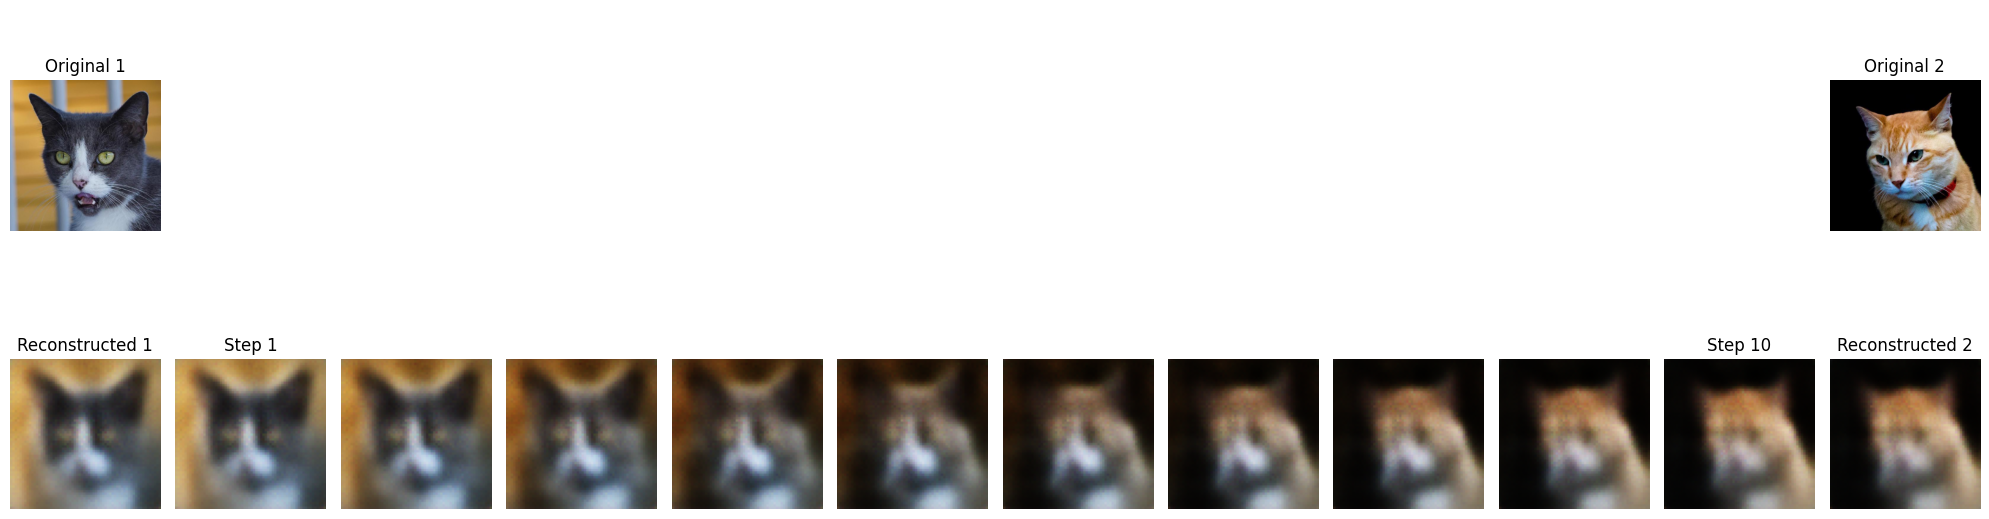

In [ ]:
def interpolate_images_advanced(model, image1_path, image2_path, steps=10, method='spherical'):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    img1 = Image.open(image1_path).convert('RGB')
    img2 = Image.open(image2_path).convert('RGB')

    img1_tensor = transform(img1).unsqueeze(0).to(DEVICE)
    img2_tensor = transform(img2).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        mu1, _ = model.encode(img1_tensor)
        mu2, _ = model.encode(img2_tensor)

        def linear_interpolation(v1, v2, alpha):
            return v1 * (1 - alpha) + v2 * alpha

        def spherical_interpolation(v1, v2, alpha):
            v1_norm = F.normalize(v1, dim=1)
            v2_norm = F.normalize(v2, dim=1)

            dot = (v1_norm * v2_norm).sum(1, keepdim=True).clamp(-1.0, 1.0)
            omega = torch.acos(dot)
            sin_omega = torch.sin(omega)

            if torch.any(sin_omega == 0):
                return linear_interpolation(v1, v2, alpha)

            term1 = torch.sin((1.0 - alpha) * omega) / sin_omega
            term2 = torch.sin(alpha * omega) / sin_omega
            return term1 * v1 + term2 * v2

        interpolation_func = spherical_interpolation if method == 'spherical' else linear_interpolation

        vectors = []
        for alpha_val in np.linspace(0, 1, steps):
            alpha_tensor = torch.tensor([[alpha_val]], dtype=mu1.dtype, device=DEVICE)
            interpolated = interpolation_func(mu1, mu2, alpha_tensor)
            vectors.append(interpolated)

        fig, axes = plt.subplots(2, steps + 2, figsize=(20, 6))

        recon1, _, _ = model(img1_tensor)
        recon2, _, _ = model(img2_tensor)

        axes[0, 0].imshow(img1)
        axes[0, 0].axis('off')
        axes[0, 0].set_title('Original 1')

        recon_img1 = recon1[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
        axes[1, 0].imshow(recon_img1.clamp(0, 1))
        axes[1, 0].axis('off')
        axes[1, 0].set_title('Reconstructed 1')

        for i, vec in enumerate(vectors):
            decoded = model.decode(vec.to(DEVICE))
            img = decoded[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
            axes[0, i + 1].axis('off')
            axes[1, i + 1].imshow(img.clamp(0, 1))
            axes[1, i + 1].axis('off')
            if i == 0 or i == steps - 1:
                axes[1, i + 1].set_title(f'Step {i + 1}')

        axes[0, -1].imshow(img2)
        axes[0, -1].axis('off')
        axes[0, -1].set_title('Original 2')

        recon_img2 = recon2[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
        axes[1, -1].imshow(recon_img2.clamp(0, 1))
        axes[1, -1].axis('off')
        axes[1, -1].set_title('Reconstructed 2')

        plt.tight_layout()
        plt.savefig(f'interpolation_{method}.png')
        plt.show()


# Przykład użycia funkcji interpolacji:
interpolate_images_advanced(model, 'afhq/train/cat/flickr_cat_000003.jpg', 'afhq/train/cat/pixabay_cat_004569.jpg', 
                            steps=10, method='spherical')